In [11]:
#Michael Owen AI Project
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [16]:
class Player:
    def __init__(self,env_size,x=False,y=False):
        if not x and not y:
            self.x = np.random.randint(0, env_size)
            self.y = np.random.randint(0, env_size)
        else:
            self.x = x #not used - was for experimenting with fixed enemy positions
            self.y = y
    def setMove(self, movement):
        #move either up,down,left,right,diagonally
        #enemies and target only have movement option 6 and 7
        if movement == 7:
            self.x += -1
            self.y +=-1
        elif movement == 6:
            self.x += 1
            self.y += 1
        elif movement == 5:
            self.x += 1
            self.y +=-1
        elif movement == 4:
            self.x +=-1
            self.y +=1
        elif movement == 3:
            self.x +=0
            self.y +=1
        elif movement == 2:
            self.x +=1
            self.y +=0
        elif movement == 1:
            self.x +=0
            self.y +=-1
        elif movement == 0:
            self.x +=-1
            self.y += 0
        self.checkbounds()
        #make x,y adjustments if not within env size bounds

  
    def checkbounds(self):
        if self.y < 0:
            self.y = 0
        elif self.y > env_size-1:
            self.y = env_size-1
        if self.x < 0:
            self.x = 0
        elif self.x > env_size-1:
            self.x = env_size-1


In [17]:
def getQ_table(env_size):
    z = np.zeros(8)#initalize the 8 action values to 0 and append as a value in the dictionary as below
    q_table = {}
    #get q-table dict
    #env_size > 9 exceeds my sytems memory capacity. 7 seems ideal for my system
    #can take some time to initialize (guesstimate 10 seconds on my system)
    #state => ((agent.x-target.x,agent.y-target.y),(agent.x-enemy.x,agent.y-enemy.y),(agent.x-enemy2.x,agent.y-enemy2.y))
    #get all possible combinations for our states shown as above
    for x1 in range(-env_size+1, env_size):
        for y1 in range(-env_size+1, env_size):
            for x2 in range(-env_size+1, env_size):
                    for y2 in range(-env_size+1, env_size):
                        for x3 in range(-env_size+1, env_size):
                            for y3 in range(-env_size+1, env_size):
                                q_table[((x1, y1), (x2, y2),(x3,y3))] = [x for x in z]

    return q_table

In [35]:
def QLearning(LearningRate,DiscountRate,env_size,episodes,enem_reward,movement_reward,target_reward,epsilon,min_eps, calc_freq, target_move):
    
    env_size = env_size
    #uniform reduction amount per episode for epsilon decay
    reduction = (epsilon - min_eps) / episodes
    episode_rewards = []
    num_succeeded = 0
    q_table = getQ_table(env_size)
    enemy_hit_count = 0
    avg_reward_list = []
    ehcl = []#for tracking how often agent moves to enemies position
    avg_ehcl = []
    for episode in range(1,episodes+1):
        done = False
        agent = Player(env_size)
        enemy = Player(env_size)
        enemy2 = Player(env_size)
        target = Player(env_size)
        #reinitialize target object if it "spawns" in same spot as agent or enemies
        if target.x == enemy2.x and target.y == enemy2.y:
            target = Player(env_size)
        elif target.x == enemy.x and target.y == enemy.y:
            target = Player(env_size)
        elif target.x == agent.x and target.y == agent.y:
            target = Player(env_size)

        episode_reward = 0
        while not done:
            #current state before taking actions
            state = ((agent.x-target.x,agent.y-target.y),(agent.x-enemy.x,agent.y-enemy.y),(agent.x-enemy2.x,agent.y-enemy2.y))
            #eps greedy strategy
            if np.random.random() > epsilon:
                action = np.argmax(q_table[state])
            else:
                action = np.random.randint(0, 8)
            #agent takes action from epsilon greedy strategy and enemy takes either action 6 or 7
            agent.setMove(action)
            enemy.setMove(np.random.randint(6,8))
            enemy2.setMove(np.random.randint(6,8))
            
            #move target as we did with enemies if we declared target_move as True
            if target_move:
                target.setMove(np.random.randint(6,8))
            
            #check if positions are equal to get respective reward
            if agent.x == enemy.x and agent.y == enemy.y:
                reward = enem_reward
            elif agent.x == enemy2.x and agent.y == enemy2.y:
                reward = enem_reward
            elif agent.x == target.x and agent.y == target.y:
                reward = target_reward
            else:
                reward = movement_reward
            #state at time t + 1
            state2 = ((agent.x-target.x,agent.y-target.y),(agent.x-enemy.x,agent.y-enemy.y),(agent.x-enemy2.x,agent.y-enemy2.y))
            max_future_q = np.max(q_table[state2])
            current_q = q_table[state][action]

            if reward == target_reward:
                q_table[state][action] = reward
                #record number of successes
                num_succeeded +=1
            else:
                delta = LearningRate * (reward + DiscountRate * np.max(q_table[state2]) - q_table[state][action])
            #adjust q value using TD
            q_table[state][action] += delta
            
            episode_reward += reward
            #show img env for last 30 episodes. Adjust env size to make it more clear.
            #may need tweeking if you adjust env_size from 7
            #target - black, enemies - red, agent - blue
            if episode >= (episodes-30):
                rbg_array = np.ones((env_size*2, env_size*2, 3), dtype=np.uint8) #uint8 for 0-256 rgb
                rbg_array[0:256, 0:256] = (255,255,255) #make env background white
                rbg_array[target.y*2][target.x*2] = (0, 0, 0)
                rbg_array[agent.y*2][agent.x*2] = (255, 255, 10)
                rbg_array[enemy.y*2][enemy.x*2] = (0, 0, 255)
                rbg_array[enemy2.x*2][enemy2.y*2] = (0, 0, 255)
                pic = Image.fromarray(rbg_array, 'RGB')
                pic = pic.resize((300, 300)) 
                cv2.imshow("i", np.array(pic)) 
                if reward == target_reward or reward == enem_reward:
                    cv2.waitKey(600)#try to slow down a bit
                else:
                    cv2.waitKey(1)

            if reward == target_reward:
                done = True
                #done with current episode
            elif reward == enem_reward:
                #track how often agent hits enemy
                enemy_hit_count +=1
                done = True
        episode_rewards.append(episode_reward)
        ehcl.append(enemy_hit_count)
        
        if episode % calc_freq == 0:
            #output episode avg reward and number of successful for calc_freq interval
            print(f"{episode} episode avg reward: {np.mean(episode_rewards)} and {num_succeeded} successes")
        #decay epsilon  
        if epsilon > min_eps:
            epsilon -= reduction
        if episode % calc_freq == 0:
            #record and reset stats
            num_succeeded = 0
            enemy_hit_count = 0
            avg_ehc = np.mean(ehcl)
            avg_ehcl.append(avg_ehc)
            ehcl = []
            avg_reward = np.mean(episode_rewards)
            episode_rewards = []
            avg_reward_list.append(avg_reward)
            
    #returning avg reward list and enemy_hit_count
    return avg_reward_list, avg_ehcl

In [36]:
#episodes = 2000000
episodes = 500000
movement_reward = -1
enem_reward = -300
target_reward = 30
epsilon = 1.0
#calc_freq = 100000
calc_freq = 5000
min_eps = 0.0
env_size = 7
LearningRate = 0.1
DiscountRate = .99
target_move = True
rewards, hit_count = QLearning(LearningRate,DiscountRate,env_size,episodes,enem_reward,movement_reward,target_reward,epsilon,min_eps,calc_freq, target_move)
cv2.destroyAllWindows()

50000 episode avg reward: -219.24572 and 15922 successes
100000 episode avg reward: -204.23002 and 17886 successes
150000 episode avg reward: -188.57368 and 19998 successes
200000 episode avg reward: -173.28866 and 22008 successes
250000 episode avg reward: -157.7869 and 24135 successes
300000 episode avg reward: -141.22006 and 26458 successes
350000 episode avg reward: -126.25048 and 28556 successes
400000 episode avg reward: -111.78692 and 30575 successes
450000 episode avg reward: -98.93022 and 32390 successes
500000 episode avg reward: -86.13966 and 34192 successes
550000 episode avg reward: -73.64946 and 35976 successes
600000 episode avg reward: -63.10918 and 37460 successes
650000 episode avg reward: -52.41234 and 38989 successes
700000 episode avg reward: -43.14236 and 40308 successes
750000 episode avg reward: -33.87632 and 41635 successes
800000 episode avg reward: -26.66596 and 42662 successes
850000 episode avg reward: -18.35576 and 43872 successes
900000 episode avg reward

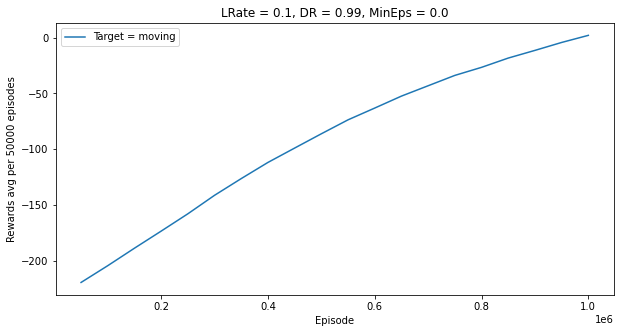

In [37]:
#plotting above results only
fig = plt.subplots(figsize =(10, 5))
plt.title(f"LRate = {LearningRate}, DR = {DiscountRate}, MinEps = {min_eps}" )
plt.plot(calc_freq * (np.arange(len(rewards[:])) +1 ), rewards[:],label = 'Target = moving')
plt.ylabel(f"Rewards avg per {calc_freq} episodes")
plt.xlabel("Episode")
plt.title(f"LRate = {LearningRate}, DR = {DiscountRate}, MinEps = {min_eps}" )
plt.legend()
plt.show()

In [38]:
#calling function again with different parameters (ie.target_move = False) to plot the results of both for comparison
#episodes = 2000000
episodes = 00000
movement_reward = -1
enem_reward = -300
target_reward = 30
epsilon = 1.0
#calc_freq = 100000  # how often to play through env visually.
calc_freq = 5000
min_eps = 0.0
env_size = 7
LearningRate = 0.1
DiscountRate = .99
target_move = False
#run to get a 2nd list of both rewards and enemy + agent_hit_counts to create a plot of both for comparison
rewards2, hit_count2 = QLearning(LearningRate,DiscountRate,env_size,episodes,enem_reward,movement_reward,target_reward,epsilon,min_eps,calc_freq, target_move = False)
cv2.destroyAllWindows()

50000 episode avg reward: -217.98872 and 16093 successes
100000 episode avg reward: -200.35508 and 18438 successes
150000 episode avg reward: -177.26692 and 21623 successes
200000 episode avg reward: -156.46158 and 24445 successes
250000 episode avg reward: -136.5744 and 27183 successes
300000 episode avg reward: -118.67366 and 29626 successes
350000 episode avg reward: -103.57802 and 31706 successes
400000 episode avg reward: -89.51218 and 33663 successes
450000 episode avg reward: -77.05348 and 35389 successes
500000 episode avg reward: -66.2078 and 36908 successes
550000 episode avg reward: -55.52552 and 38400 successes
600000 episode avg reward: -48.41332 and 39381 successes
650000 episode avg reward: -40.25108 and 40525 successes
700000 episode avg reward: -33.31688 and 41492 successes
750000 episode avg reward: -26.17734 and 42507 successes
800000 episode avg reward: -20.8808 and 43250 successes
850000 episode avg reward: -15.65838 and 43979 successes
900000 episode avg reward: -

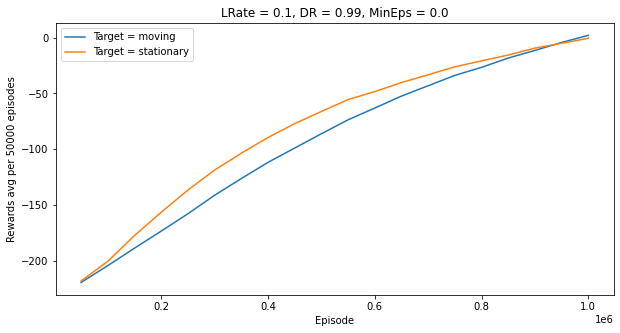

In [39]:
#plotting rewards and rewards2 after running the Q_learning function twice
fig = plt.subplots(figsize =(10, 5))
plt.title(f"LRate = {LearningRate}, DR = {DiscountRate}, MinEps = {min_eps}" )
plt.plot(calc_freq * (np.arange(len(rewards[:])) +1 ), rewards[:],label = 'Target = moving')
plt.plot(calc_freq * (np.arange(len(rewards2[:])) +1 ), rewards2[:],label = 'Target = stationary')
plt.ylabel(f"Rewards avg per {calc_freq} episodes")
plt.xlabel("Episode")
plt.title(f"LRate = {LearningRate}, DR = {DiscountRate}, MinEps = {min_eps}" )
plt.legend()
plt.show()

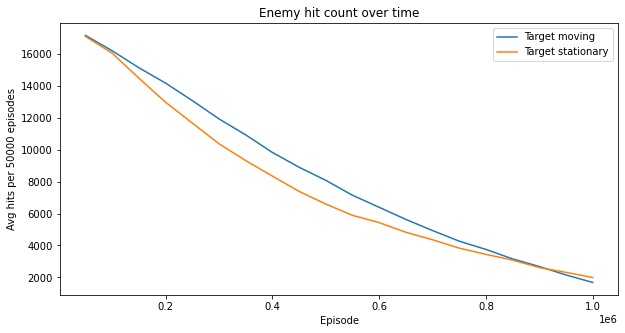

In [40]:
#plot the enemy hit counts after running the q_learning function twice
fig = plt.subplots(figsize =(10, 5))
plt.title("Enemy hit count over time" )
plt.plot(calc_freq * (np.arange(len(hit_count[:])) + 1), hit_count[:],label = "Target moving")
plt.plot(calc_freq * (np.arange(len(hit_count2[:])) + 1), hit_count2[:], label = "Target stationary")
plt.xlabel("Episode")
plt.ylabel(f"Avg hits per {calc_freq} episodes")
plt.legend()
plt.show()